<a href="https://colab.research.google.com/github/mbibrahe/BA_Project/blob/main/FS_UNET%2B%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from __future__ import print_function
import glob
import os
import gc

import keras
import keras.backend as K
from keras.preprocessing import image as kImage
from keras import regularizers
from keras.regularizers import l2
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, AveragePooling2D, GlobalAveragePooling3D
from keras.models import Sequential
from keras.layers.convolutional import Deconv2D
from keras.layers import Activation, Input, Dropout, BatchNormalization, SpatialDropout2D, LayerNormalization, UpSampling2D, Conv2DTranspose
from keras.layers.merge import concatenate, Average
from tensorflow.keras.callbacks import Callback

from PIL import Image as PILimage
import matplotlib.pyplot as plt
from matplotlib import image as imageMat
from sklearn.datasets import load_sample_image
from sklearn.feature_extraction import image as Image
from sklearn.utils import class_weight
from sklearn import metrics

import cv2 as cv
import math
import numpy as np
import random as rn


from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)




In [ ]:

download = drive.CreateFile({'id': '1v_WJpuMAPS22rVRiy4Qytvv8wUWIh-WW'})
download.GetContentFile("baseline_new.zip")


! unzip baseline_new.zip

Streaming output truncated to the last 5000 lines.
  inflating: Baseline_new/train/y/4/gt000583.png  
  inflating: Baseline_new/train/y/4/gt000584.png  
  inflating: Baseline_new/train/y/4/gt000585.png  
  inflating: Baseline_new/train/y/4/gt000586.png  
  inflating: Baseline_new/train/y/4/gt000587.png  
  inflating: Baseline_new/train/y/4/gt000588.png  
  inflating: Baseline_new/train/y/4/gt000589.png  
  inflating: Baseline_new/train/y/4/gt000590.png  
  inflating: Baseline_new/train/y/4/gt000591.png  
  inflating: Baseline_new/train/y/4/gt000592.png  
  inflating: Baseline_new/train/y/4/gt000593.png  
  inflating: Baseline_new/train/y/4/gt000594.png  
  inflating: Baseline_new/train/y/4/gt000595.png  
  inflating: Baseline_new/train/y/4/gt000596.png  
  inflating: Baseline_new/train/y/4/gt000597.png  
  inflating: Baseline_new/train/y/4/gt000598.png  
  inflating: Baseline_new/train/y/4/gt000599.png  
  inflating: Baseline_new/train/y/4/gt000600.png  
  inflating: Baseline_new/train

In [ ]:
download = drive.CreateFile({'id': '10I1TfpKPvvVEHwSFYbUGM4LNab-WfvYE'})
download.GetContentFile("basetest_1.zip")


! unzip basetest_1.zip

Archive:  basetest_1.zip
   creating: basetest_1/test/
   creating: basetest_1/test/x/
  inflating: basetest_1/test/x/in000300.jpg  
  inflating: basetest_1/test/x/in000313.jpg  
  inflating: basetest_1/test/x/in000438.jpg  
  inflating: basetest_1/test/x/in000444.jpg  
  inflating: basetest_1/test/x/in000464.jpg  
  inflating: basetest_1/test/x/in000530.jpg  
  inflating: basetest_1/test/x/in000560.jpg  
  inflating: basetest_1/test/x/in000586.jpg  
  inflating: basetest_1/test/x/in000595.jpg  
  inflating: basetest_1/test/x/in000600.jpg  
  inflating: basetest_1/test/x/in000635.jpg  
  inflating: basetest_1/test/x/in000650.jpg  
  inflating: basetest_1/test/x/in000695.jpg  
  inflating: basetest_1/test/x/in000700.jpg  
  inflating: basetest_1/test/x/in000710.jpg  
  inflating: basetest_1/test/x/in000728.jpg  
  inflating: basetest_1/test/x/in000730.jpg  
  inflating: basetest_1/test/x/in000799.jpg  
  inflating: basetest_1/test/x/in000800.jpg  
  inflating: basetest_1/test/x/in000835

In [ ]:


#Unet++: A Nested U-Net Architecture for Medical Image Segmentation
#Zhou, Zongwei and Siddiquee, Md Mahfuzur Rahman and Tajbakhsh, Nima and Liang, Jianming
#Deep Learning in Medical Image Analysis and Multimodal Learning for Clinical Decision Support
#2018
#https://github.com/MrGiovanni/UNetPlusPlus

smooth = 1.
dropout_rate = 0.2

def standard_unit(input_tensor, stage, nb_filter, kernel_size=3):

    act = None

    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation=act, kernel_initializer = 'he_normal', padding='same')(input_tensor)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation=act, kernel_initializer = 'he_normal', padding='same')(x)
    x = Activation('relu')(x)


    return x

def unet_mod(input1_):

  nb_filter = [32,64,128,256,512]

  conv1_1 = standard_unit(input1_, stage='11', nb_filter=nb_filter[0]) #0,0 
  pool1 = MaxPooling2D((2, 2), strides=(2, 2))(conv1_1)
  

  conv2_1 = standard_unit(pool1, stage='21', nb_filter=nb_filter[1]) #1,0
  pool2 = MaxPooling2D((2, 2), strides=(2, 2))(conv2_1)

  up1_2 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv2_1) #0,1
  conv1_2 = concatenate([up1_2, conv1_1], axis=3)
  conv1_2 = standard_unit(conv1_2, stage='12', nb_filter=nb_filter[0])

  conv3_1 = standard_unit(pool2, stage='31', nb_filter=nb_filter[2]) #2,0
  pool3 = MaxPooling2D((2, 2), strides=(2, 2))(conv3_1)

  up2_2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv3_1) #1,1
  conv2_2 = concatenate([up2_2, conv2_1], axis=3)
  conv2_2 = standard_unit(conv2_2, stage='22', nb_filter=nb_filter[1])


  up1_3 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv2_2) #0,2
  conv1_3 = concatenate([up1_3, conv1_1, conv1_2], axis=3)
  conv1_3 = standard_unit(conv1_3, stage='13', nb_filter=nb_filter[0])



  conv4_1 = standard_unit(pool3, stage='41', nb_filter=nb_filter[3]) #3,0
  pool4 = MaxPooling2D((2, 2), strides=(2, 2))(conv4_1)

  up3_2 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv4_1) #2,1
  conv3_2 = concatenate([up3_2, conv3_1], axis=3)
  conv3_2 = standard_unit(conv3_2, stage='32', nb_filter=nb_filter[2])


  up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), padding='same')(conv3_2) #1,2
  conv2_3 = concatenate([up2_3, conv2_1, conv2_2], axis=3)
  conv2_3 = standard_unit(conv2_3, stage='23', nb_filter=nb_filter[1])


  up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), padding='same')(conv2_3) #0,3
  conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], axis=3)
  conv1_4 = standard_unit(conv1_4, stage='14', nb_filter=nb_filter[0])


  conv5_1 = standard_unit(pool4, stage='51', nb_filter=nb_filter[4]) #4,0


  up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), padding='same')(conv5_1) #3,1
  conv4_2 = concatenate([up4_2, conv4_1], axis=3)
  conv4_2 = standard_unit(conv4_2, stage='42', nb_filter=nb_filter[3])


  up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), padding='same')(conv4_2) #2,2
  conv3_3 = concatenate([up3_3, conv3_1, conv3_2], axis=3)
  conv3_3 = standard_unit(conv3_3, stage='33', nb_filter=nb_filter[2])


  up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), padding='same')(conv3_3) #1,3
  conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], axis=3)
  conv2_4 = standard_unit(conv2_4, stage='24', nb_filter=nb_filter[1])


  up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), padding='same')(conv2_4) #0,4
  conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], axis=3)
  conv1_5 = standard_unit(conv1_5, stage='15', nb_filter=nb_filter[0])


  #Deep supervision
  nestnet_output_1 = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_2)
  nestnet_output_2 = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_3)
  nestnet_output_3 = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_4)
  nestnet_output_4 = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_5)
  


  deep_ = tf.keras.layers.Average()([nestnet_output_1, nestnet_output_2, nestnet_output_3, nestnet_output_4])

  return deep_


In [ ]:






dataset_path = os.path.join('Baseline_new')

def getData(dataset_dir):
    
    
    
    X_list= sorted(glob.glob(os.path.join(dataset_path, 'train', 'x','*','*.jpg')))
    
    

    Y_list= sorted(glob.glob(os.path.join(dataset_path, 'train', 'y','*','*.png')))
    


    Z_list= sorted(glob.glob(os.path.join(dataset_path, 'train', 'z','*','*.jpg')))



    X= []
    Y= []
    Z= []

    

    print(len(X_list))
    
    for i in range(0, len(X_list)):
        
        
        # Load input images
        x1 = cv.resize(cv.imread(X_list[i]), (320, 240))
        normalizedImg1 = np.zeros((320, 240))
        normalizedImg1 = cv.normalize(x1,  normalizedImg1, 0, 255, cv.NORM_MINMAX)
        X.append(normalizedImg1)
      
        # Load ground truth images
        y = cv.resize(cv.imread(Y_list[i], 0), (320, 240))
        y = cv.normalize(y, None, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
        Y.append(y)

        # Load background images
        z1 = cv.resize(cv.imread(Z_list[i]), (320, 240))
        normalizedImg1 = np.zeros((320, 240))
        normalizedImg1 = cv.normalize(z1,  normalizedImg1, 0, 255, cv.NORM_MINMAX)
        Z.append(normalizedImg1)
        
        
    
            
    X = np.asarray(X)
    Y = np.asarray(Y)
    Z = np.asarray(Z)

    
    # Shuffle the training data
    idx = list(range(X.shape[0]))
    np.random.shuffle(idx)
    X = X[idx]
    Y = Y[idx]
    Z = Z[idx]


    return X, Y, Z




X, Y, Z = getData(dataset_path)


tf.random.set_seed(8)

def initModel():
    
    
    img_1 = Input(shape=(None, None ,3))
    img_2 = Input(shape=(None, None ,3))
    
    out1 = unet_mod(img_1)
    out2 = unet_mod(img_2)
   
    x = tf.keras.layers.Average()([out1, out2])

    x = Dense(2)(x)

    out_d = Dense(1, activation='sigmoid', kernel_regularizer=l2(1e-4))(x)
    

    
    model = Model([img_1, img_2], outputs=out_d)
    model.summary()


    model.compile(optimizer="rmsprop",
              loss='binary_crossentropy',
              metrics=['accuracy'])

    
    return model



    


model = initModel()


patches_bi = []
patches_in = []
patches_bt = []


# Stacking the background image and input images, for every frame

patch_size = (32, 32)

for i in range(len(X)):
    data_in = Image.extract_patches_2d(X[i], patch_size, max_patches=100, random_state=1)
    data_bt = Image.extract_patches_2d(Y[i], patch_size, max_patches=100, random_state=1)
    data_bi = Image.extract_patches_2d(Z[i], patch_size, max_patches=100, random_state=1)
    patches_in.append(data_in)
    patches_bt.append(data_bt)
    patches_bi.append(data_bi)




patches_in = np.concatenate(patches_in)
patches_bt = np.concatenate(patches_bt)
patches_bi = np.concatenate(patches_bi)

                                           
model.fit([patches_in, patches_bi], y=patches_bt, batch_size=600, epochs=50, verbose=1, validation_split=0.2, shuffle=True)


model.save('my_model.h5')




4381
Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_718 (Conv2D)             (None, None, None, 3 896         input_23[0][0]                   
__________________________________________________________________________________________________
conv2d_752 (Conv2D)             (None, None, None, 3 896         input_24[0][0]                   
______________________________________________________________________________________

In [ ]:

from google.colab import drive
drive.mount ('/content/drive')



Mounted at /content/drive


In [ ]:
import datetime

x = datetime.datetime.now()

model.save('/content/drive/My Drive/Colab Notebooks/my_model_base_' + str(x.day))

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/my_model_base_610/assets


In [ ]:
model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/my_model_base_610')

(32, 240, 320, 3)
32/32 [==============================] - 29s 22ms/step
Average dice score over 32 predictions is: 0.8574055928284233
Dice score for this image: 0.833075255497058


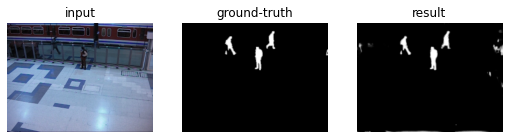

In [ ]:


dataset_path = os.path.join('basetest_1', 'test')
def getData_test(dataset_dir):
    X_list= sorted(glob.glob(os.path.join(dataset_dir, 'x','*.jpg')))
    Y_list = sorted(glob.glob(os.path.join(dataset_dir, 'y' ,'*.png')))
    
    
    X= []
    Y= []
    
    for i in range(0, len(X_list)):
        # Load input images
        x = cv.resize(cv.imread(X_list[i]), (320, 240))
        normalizedImg = np.zeros((320, 240))
        normalizedImg = cv.normalize(x,  normalizedImg, 0, 255, cv.NORM_MINMAX)
        X.append(normalizedImg)
        
        # Load ground truth images
        y = cv.resize(cv.imread(Y_list[i], 0), (320, 240))
        y = cv.normalize(y, None, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
        Y.append(y)


            
    X = np.asarray(X)
    Y = np.asarray(Y)
    
    # Shuffle the training data
    """idx = list(range(X.shape[0]))
    np.random.shuffle(idx)
    X = X[idx]
    Y = Y[idx]"""

    return X, Y
X, Y = getData_test(dataset_path)




# Prediction 
pred = model.predict([X,X], verbose=1, batch_size=1)




plt.rcParams['figure.figsize'] = (12.0, 9.0)



idx = 6 # image index in a range of [0,9]

img = np.empty(3, dtype=object)
img[0] = X[idx]
img[1] = Y[idx].reshape(Y[idx].shape[0],Y[idx].shape[1])

img[2] = pred[idx].reshape(pred[idx].shape[0],pred[idx].shape[1])



def compute_dice(im1, im2, empty_score=1.0):
    y_true_f = K.flatten(im1)
    y_pred_f = K.flatten(im2)
    im1 = np.asarray(y_true_f>0.5).astype(np.bool)
    im2 = np.asarray(y_pred_f>0.5).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score

    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / im_sum




te_ = []

for i in range(0,len(X)):
  te_.append(compute_dice(Y[i], pred[i]))

dice_avg = sum(te_)/len(te_)

print("Average dice score over " + str(len(te_)) + " predictions is: "  + str(dice_avg))

print("Dice score for this image: " + str(compute_dice(Y[idx], pred[idx])))

title = ['input', 'ground-truth', 'result']
for i in range(3):
  plt.subplot(1, 4, i+1)
  if i==0:
    plt.imshow(img[i].astype('uint8'))
  else:
    plt.imshow(img[i], cmap='gray')
  
  plt.axis('off')
  plt.title(title[i])


plt.show()



